# Home Work 5

### Importing Necessary packages and dependecies

In [1577]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import math
%matplotlib inline
sns.set()

#Used in order to avoid warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the census_train and census_data

In [931]:
trainfile = pd.read_csv("census_train.csv", header = None)

In [932]:
testfile = pd.read_csv("census_test.csv", header = None)

In [933]:
trainfile.columns = ['idnum', 'age', 'workerclass', 'interestincome', 'traveltimetowork', 'vehicleoccupancy', 
                     'meansoftransport', 'marital', 'schoolenrollment', 'educationalattain', 'sex', 'workarrivaltime', 
                     'hoursworkperweek', 'ancestry', 'degreefield', 'industryworkedin', 'wages' ]
testfile.columns = ['idnum', 'age', 'workerclass', 'interestincome', 'traveltimetowork', 'vehicleoccupancy', 
                     'meansoftransport', 'marital', 'schoolenrollment', 'educationalattain', 'sex', 'workarrivaltime', 
                     'hoursworkperweek', 'ancestry', 'degreefield', 'industryworkedin']


Here we check the no. of '?' elements in each feature



In [934]:
for i in trainfile.columns:
    print(i,trainfile[i].dtype)
    if trainfile[i].dtype == object:
        print("na values=",len(trainfile[trainfile[i]=="?"]))

idnum int64
age int64
workerclass object
na values= 378
interestincome int64
traveltimetowork object
na values= 576
vehicleoccupancy object
na values= 775
meansoftransport object
na values= 543
marital int64
schoolenrollment int64
educationalattain int64
sex int64
workarrivaltime object
na values= 576
hoursworkperweek object
na values= 465
ancestry int64
degreefield object
na values= 766
industryworkedin object
na values= 378
wages int64


### Data Cleaning and PreProcessing

Based on the '?' values and categorical attributes we change it to 0(indicates another value) and convert all the attributes to numeric data type

In [935]:
trainfile = trainfile.replace("?",0)
testfile = testfile.replace("?", 0)

In [937]:
for i in trainfile.columns:
    trainfile[i] = pd.to_numeric(trainfile[i])
    
    
for i in testfile.columns:
    testfile[i] = pd.to_numeric(testfile[i])

Create a correlation Matrix to find the redundant features in order to remove them

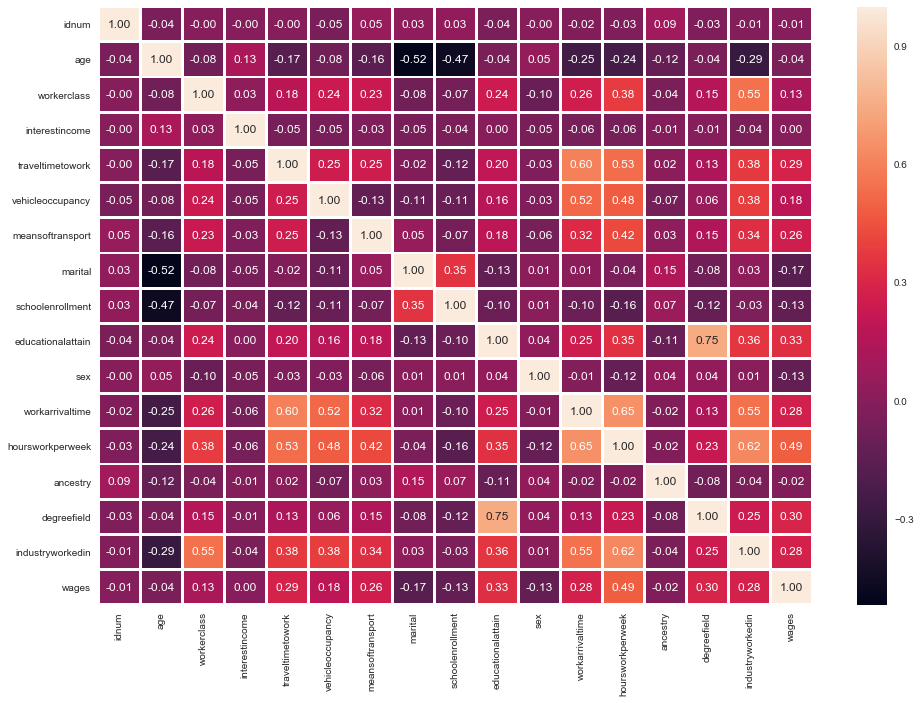

In [938]:
corr = trainfile.corr()

f,ax = plt.subplots(figsize=(16,11))
sns.heatmap(corr, annot = True, linewidths=1.8 , fmt = '.2f',ax=ax)
plt.show()

#### Set the index to the id no and remove the redundant features

In [939]:
trainfile.set_index('idnum', inplace=True)
testfile.set_index('idnum', inplace=True)

In [54]:
trainfile.head()

,age,workerclass,interestincome,traveltimetowork,vehicleoccupancy,meansoftransport,marital,schoolenrollment,educationalattain,sex,workarrivaltime,hoursworkperweek,ancestry,degreefield,industryworkedin,wages
idnum,,,,,,,,,,,,,,,,
0,58,3,0,40,2,1,1,1,22,1,84,40,32,2300,7870,110000
1,34,3,0,10,1,1,5,1,16,1,168,40,51,0,7860,34500
2,57,2,0,15,8,1,5,1,16,1,100,30,51,0,8390,4700
3,17,0,0,0,0,0,5,2,15,2,0,0,714,0,0,0
4,42,1,0,20,1,1,1,1,22,1,92,45,21,5001,6990,120000


In [942]:
redundant_features = ['age','interestincome','marital','schoolenrollment','sex','ancestry','wages']
cleaned_train = trainfile.drop(redundant_features, axis=1)

redundant_features = ['age','interestincome','marital','schoolenrollment','sex','ancestry']
cleaned_test = testfile.drop(redundant_features, axis=1)

In [943]:
cleaned_train.head()

,workerclass,traveltimetowork,vehicleoccupancy,meansoftransport,educationalattain,workarrivaltime,hoursworkperweek,degreefield,industryworkedin
idnum,,,,,,,,,
0,3,40,2,1,22,84,40,2300,7870
1,3,10,1,1,16,168,40,0,7860
2,2,15,8,1,16,100,30,0,8390
3,0,0,0,0,15,0,0,0,0
4,1,20,1,1,22,92,45,5001,6990


*Preprocessing*: Here we use binning to simplify the multiple categories of `workarrivatime,degreefield,industryworkedin` feature

In [355]:
def preprocess(data):
    
    #Binning is based on the poppular shifts across US
    workarrivaltime_bins = [0, 82, 112, 142, 178, 208, 226, 250, 286]
    data['work_arrival_slot'] = pd.cut(data['workarrivaltime'], workarrivaltime_bins, include_lowest=True)
    
    #Binning is based on similar fields
    degreefild_bins = np.arange(0,6501,100)
    data['degreefield_slot'] = pd.cut(data['degreefield'], degreefild_bins, include_lowest=True)
    
    #Binning is based on similar fields
    industry_bins = np.arange(0,10001, 100)
    data['industry_slot'] = pd.cut(data['industryworkedin'], industry_bins, include_lowest=True)
    
    for i in data.index:
        data.loc[i, 'arrival_time'] = data.loc[i, 'work_arrival_slot'].mid
        data.loc[i, 'degree_field'] = data.loc[i, 'degreefield_slot'].mid
        data.loc[i, 'industry_field'] = data.loc[i, 'industry_slot'].mid
        
    return data

In [944]:
fixed_df = preprocess(cleaned_train)
test_df = preprocess(cleaned_test)

#### Remove the fixed features

In [945]:
fixed_cols = ['workarrivaltime','work_arrival_slot','degreefield_slot','degreefield','industry_slot','industryworkedin']
fixed_df = fixed_df.drop(fixed_cols, axis=1)
test_df = test_df.drop(fixed_cols, axis=1)

Here we have plotted one of the most important feature: `Degree field`

Text(0.5,0,'Degree Type')

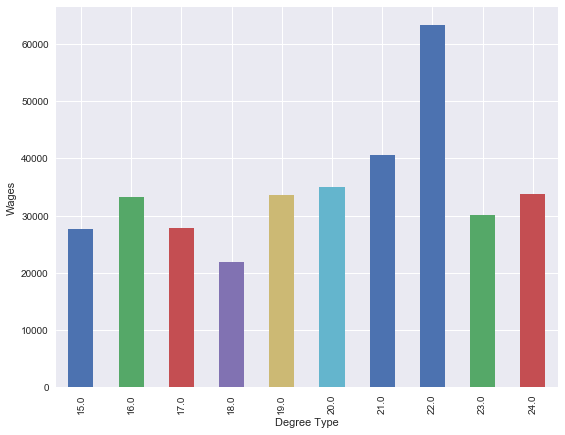

In [946]:
f,ax = plt.subplots(figsize=(9,7))
pd.concat([fixed_df,y], axis=1).groupby('educationalattain').wages.mean().plot(kind='bar',)
plt.ylabel("Wages")
plt.xlabel("Degree Type")

In [947]:
fixed_df.head()

,workerclass,traveltimetowork,vehicleoccupancy,meansoftransport,educationalattain,hoursworkperweek,arrival_time,degree_field,industry_field
idnum,,,,,,,,,
0,3,40,2,1,22,40,97.0000,2250.0000,7850.0000
1,3,10,1,1,16,40,160.0000,49.9995,7850.0000
2,2,15,8,1,16,30,97.0000,49.9995,8350.0000
3,0,0,0,0,15,0,40.9995,49.9995,49.9995
4,1,20,1,1,22,45,97.0000,5050.0000,6950.0000


### Scaling the Attributes

The main advantage of scaling is to avoid attributes in greater numeric ranges dominating those in smaller numeric ranges   
Here We have used MinMaxScaler which scales value between 0,1

In [948]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
scaler_x = MinMaxScaler().fit(fixed_df)
scaler_y = MinMaxScaler().fit(y.values.reshape(-1, 1))

scaled_train = scaler_x.transform(fixed_df)
scaled_y = scaler_y.transform(y.values.reshape(-1, 1))

pdcols = ['workerclass','traveltimetowork','vehicleocupancy','meansoftransport','educationalattain','hoursperweek',
          'arrival_time','degree_field','industry_field']

scaled_train = pd.DataFrame(scaled_train, columns=pdcols)
scaled_y = pd.DataFrame(y, columns = ["wages"])

In [1440]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
scaler_x = MinMaxScaler().fit(test_df)
scaled_test = scaler_x.transform(test_df)

pdcols = ['workerclass','traveltimetowork','vehicleocupancy','meansoftransport','educationalattain','hoursperweek',
          'arrival_time','degree_field','industry_field']

scaled_test = pd.DataFrame(scaled_test, columns=pdcols)


In [949]:
scaled_train.describe()

,workerclass,traveltimetowork,vehicleocupancy,meansoftransport,educationalattain,hoursperweek,arrival_time,degree_field,industry_field
count,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000
mean,0.170233,0.121848,0.048247,0.128449,0.401370,0.234499,0.137350,0.248060,0.462915
std,0.212396,0.179067,0.075590,0.226351,0.301059,0.213417,0.197284,0.368676,0.370194
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
50%,0.111111,0.025362,0.000000,0.083333,0.444444,0.303030,0.000000,0.000000,0.616162
75%,0.222222,0.217391,0.125000,0.083333,0.666667,0.404040,0.246698,0.515625,0.787879
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Plot the feature Distribution

workerclass


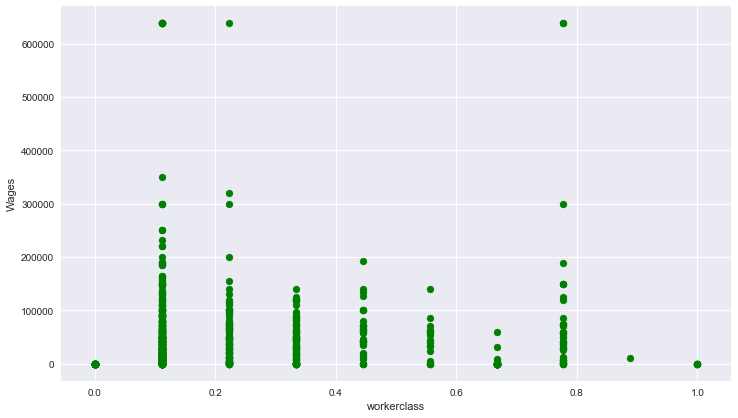

traveltimetowork


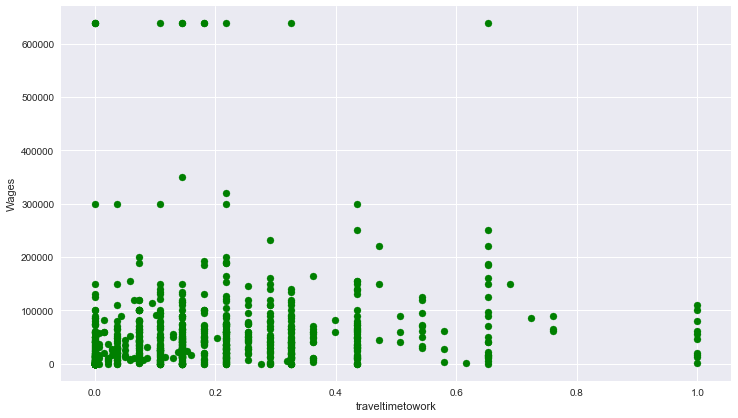

vehicleocupancy


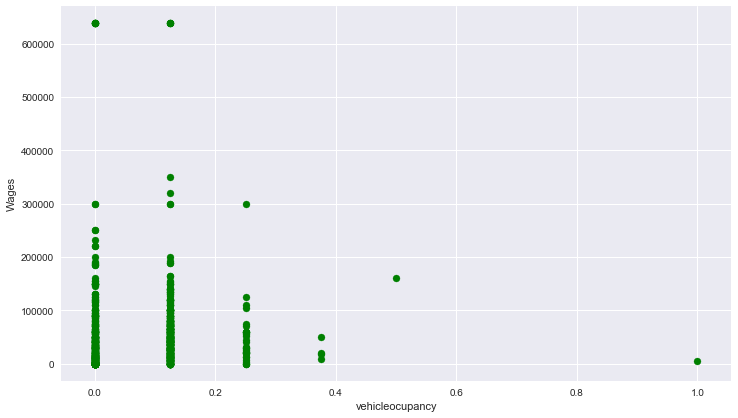

meansoftransport


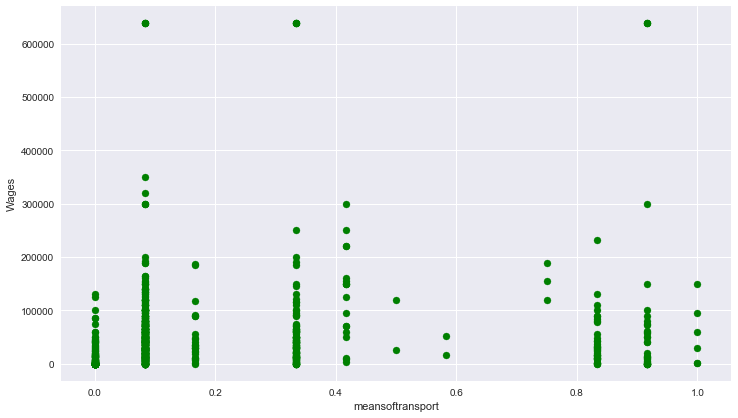

educationalattain


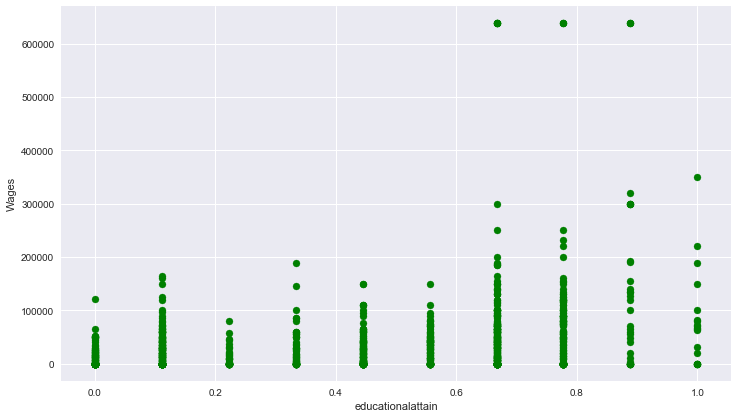

hoursperweek


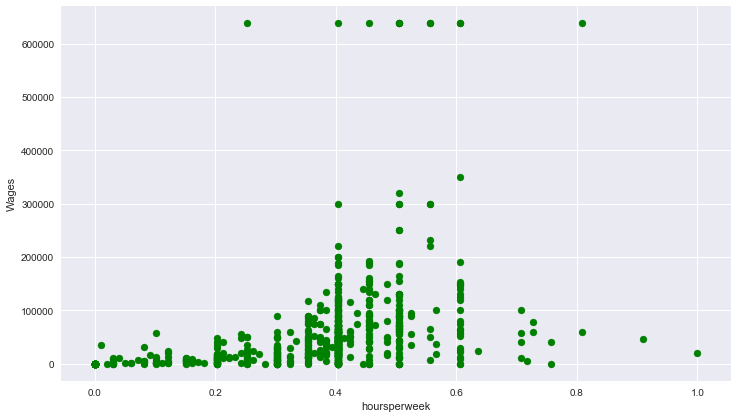

arrival_time


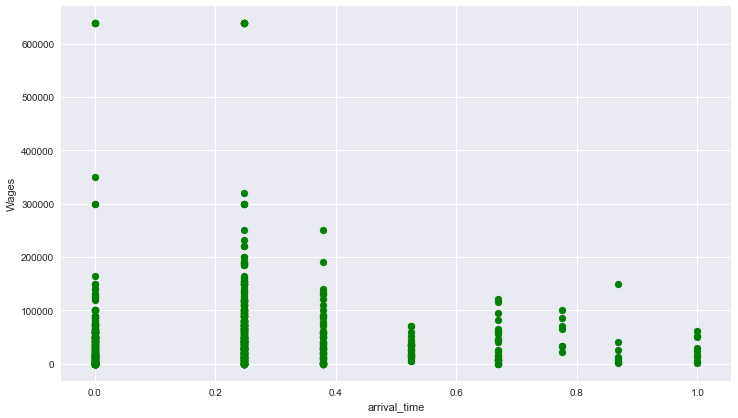

degree_field


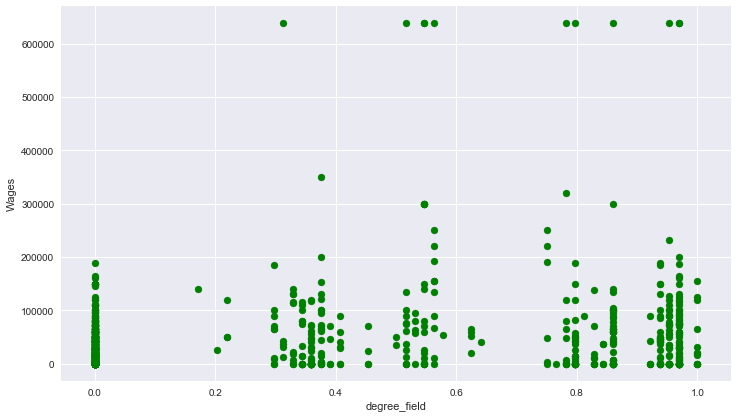

industry_field


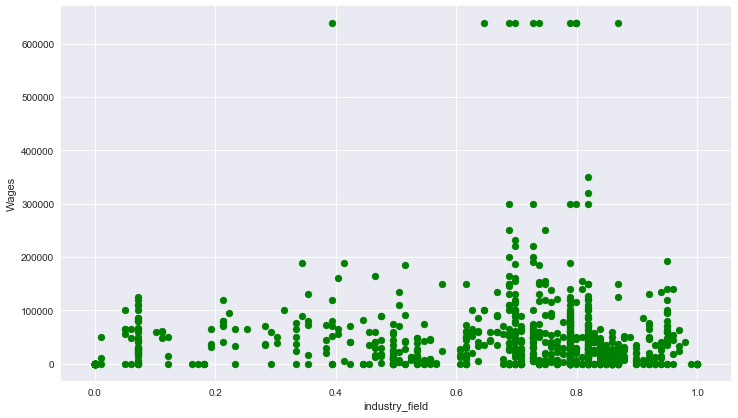

In [950]:
plt.rcParams['figure.subplot.bottom'] = 0.23  

for col in scaled_train.columns:
    print(col)
    feat = scaled_train[col]
    plt.figure(figsize = (12, 8))
    plt.scatter(feat, y, c='g')
    plt.ylabel("Wages")
    plt.xlabel(col)
    plt.show()

## Regression Models

In [1631]:
#Split the dataset into training and testing on the census_train file
#Splitting 75%-25%
x_train, x_test, y_train, y_test = np.array(train_test_split(scaled_train, scaled_y, train_size = 0.75))

## 1. Linear Regression and Polynomial Regression

In [1576]:
#Load Linear Regression and Polynomial Regression

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
preds = LR_model.predict(x_test)

MSE_Linear = mse(y_test, preds)
    
PLR_model = Pipeline([('poly', PolynomialFeatures(degree = 2)),('linear', LinearRegression())])

PLR_model.fit(x_train, y_train)
preds = np.array(PLR_model.predict(x_test))

MSE_Poly = mse(y_test, preds)
print("Linear Regression Rmse=",math.sqrt(MSE_Linear))
print("Poly Regression rmse=",math.sqrt(MSE_Poly))


Linear Regression Rmse= 37059.721670505874
Poly Regression rmse= 42370.946022529584


## 2.Lasso Regression

In [1652]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.03,precompute=True,max_iter=1000,
            positive=True, selection='random',fit_intercept=True)
MSE =49000*49000
while math.sqrt(MSE)>37000:
    x_train, x_test, y_train, y_test = np.array(train_test_split(scaled_train, scaled_y, train_size = 0.75))
    lin.fit(x_train,y_train)

    preds = lin.predict(x_test)

    MSE = mse(y_test, preds)
print("Lasso rmse=",math.sqrt(MSE))

Lasso rmse= 36546.6101384719


## 3.Decision Tree Regressor

In [1656]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

print("Error in Decision Tree Regressor:")
for i in [10,20,30,50,70,100]:
    print("Min sample leaves:", i)
    dat = DecisionTreeRegressor(min_samples_leaf=i)
    dat.fit(x_train,y_train)
    preds = dat.predict(x_test)                    

    MSE = mse(y_test, preds)
    print("rmse:",math.sqrt(MSE))

Error in Decision Tree Regressor:
Min sample leaves: 10
rmse: 42323.176654867304
Min sample leaves: 20
rmse: 37027.77805019394
Min sample leaves: 30
rmse: 35776.21661475761
Min sample leaves: 50
rmse: 34722.34808316169
Min sample leaves: 70
rmse: 39229.402442094644
Min sample leaves: 100
rmse: 37667.85308780998


## 4.Random Forest Regressor

In [1695]:
print("Random Forest Tree Model")

for i in [10,20,30,50,70,100]:
    print("Min sample leaves:",i)
    for j in np.arange(1,51, 5):
        RF_model = RandomForestRegressor(min_samples_leaf=i, max_features='log2', n_estimators=j)
        RF_model.fit(x_train,y_train)

        preds = RF_model.predict(x_test)                    

        MSE = mse(y_test, preds)
        print("No of trees:", j, "rmse:",math.sqrt(MSE))

Random Forest Tree Model
Min sample leaves: 10
No of trees: 1 rmse: 35921.70805329208
No of trees: 6 rmse: 31364.971654999714
No of trees: 11 rmse: 30544.191471268314
No of trees: 16 rmse: 31083.92696759417
No of trees: 21 rmse: 30629.6317189409
No of trees: 26 rmse: 30489.82608781168
No of trees: 31 rmse: 29966.821933082858
No of trees: 36 rmse: 30735.41594924796
No of trees: 41 rmse: 30021.02769058296
No of trees: 46 rmse: 30202.260979845454
Min sample leaves: 20
No of trees: 1 rmse: 36785.48928619833
No of trees: 6 rmse: 30450.753813845906
No of trees: 11 rmse: 31663.32887350841
No of trees: 16 rmse: 31064.03136350612
No of trees: 21 rmse: 31022.967998961096
No of trees: 26 rmse: 30339.94834024948
No of trees: 31 rmse: 30088.898315501745
No of trees: 36 rmse: 30635.528919896795
No of trees: 41 rmse: 30344.34551085361
No of trees: 46 rmse: 30166.8780854306
Min sample leaves: 30
No of trees: 1 rmse: 41631.93955164261
No of trees: 6 rmse: 32811.134642188874
No of trees: 11 rmse: 32549.

In [1706]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(min_samples_leaf=30,max_features='log2', n_estimators=13)
RF_model.fit(x_train,y_train)

preds = RF_model.predict(x_test)                    

MSE = mse(y_test, preds)
print("Random Forest final rmse:",math.sqrt(MSE))

Random Forest final rmse: 32520.690337775373


## 5.ElasticNet Regressor

In [1660]:
from sklearn.linear_model import ElasticNet

er = ElasticNet(alpha = 0.005,l1_ratio=0.5 )
er.fit(x_train,y_train)

preds = er.predict(x_test)                    
            
MSE = mse(y_test, preds)
print("Elastic Net rmse:",math.sqrt(MSE))

Elastic Net rmse: 35917.427444231915


## 6.Ridge Regressor

In [1685]:
from sklearn.linear_model import Ridge

re = Ridge(normalize=True, alpha = 0.01)
re.fit(x_train,y_train)
preds = re.predict(x_test)                    
            
MSE = mse(y_test, preds)
print("Ridge rmse:",math.sqrt(MSE))

Ridge rmse: 36217.24688873052


## Final Model Selected : Random Forest Regressor

#### Cross Validation

In [1729]:
# Deploying Cross validation for the final method selected: Random Forest

mselist=[]
num_folds = 10
subset_size = len(scaled_train)/num_folds
for i in range(num_folds):
    
    #print(i*subset_size,subset_size)
    testing_this_round = scaled_train[int(i*subset_size):][:int(subset_size)]
    training_this_round = pd.concat([scaled_train[:int(i*subset_size)],scaled_train[int((i+1)*subset_size):]])

    y_testing_this_round = scaled_y[int(i*subset_size):][:int(subset_size)]
    y_training_this_round = pd.concat([scaled_y[:int(i*subset_size)],scaled_y[int((i+1)*subset_size):]])

    RF_model = RandomForestRegressor(min_samples_leaf=30,max_features='log2', n_estimators=13)
    print(training_this_round)
    RF_model.fit(training_this_round,y_training_this_round)

    preds = RF_model.predict(testing_this_round)                    

    MSE= mse(y_testing_this_round, preds)
    print("Rmse in this round:", math.sqrt(mse(y_testing_this_round, preds)))
    mselist.append(int(MSE))
print("Final rmse:",math.sqrt(np.mean(mselist)))

      workerclass  traveltimetowork  vehicleocupancy  meansoftransport  \
118      0.000000          0.000000            0.000          0.000000   
119      0.111111          0.289855            0.125          0.083333   
120      0.111111          0.181159            0.125          0.083333   
121      0.000000          0.000000            0.000          0.000000   
122      0.111111          0.181159            0.000          0.333333   
123      0.000000          0.000000            0.000          0.000000   
124      0.111111          0.253623            0.125          0.083333   
125      0.000000          0.000000            0.000          0.000000   
126      0.111111          0.326087            0.000          0.333333   
127      0.000000          0.000000            0.000          0.000000   
128      0.555556          0.253623            0.125          0.083333   
129      0.555556          0.217391            0.000          0.333333   
130      0.333333          0.289855   

      workerclass  traveltimetowork  vehicleocupancy  meansoftransport  \
0        0.333333          0.289855            0.250          0.083333   
1        0.333333          0.072464            0.125          0.083333   
2        0.222222          0.108696            1.000          0.083333   
3        0.000000          0.000000            0.000          0.000000   
4        0.111111          0.144928            0.125          0.083333   
5        0.000000          0.000000            0.000          0.000000   
6        0.111111          0.000000            0.000          0.000000   
7        0.222222          0.000000            0.000          0.000000   
8        0.111111          0.036232            0.000          1.000000   
9        0.222222          0.362319            0.000          0.333333   
10       0.000000          0.000000            0.000          0.000000   
11       0.777778          0.007246            0.000          0.833333   
12       0.777778          0.217391   

Rmse in this round: 61702.168516585036
      workerclass  traveltimetowork  vehicleocupancy  meansoftransport  \
0        0.333333          0.289855            0.250          0.083333   
1        0.333333          0.072464            0.125          0.083333   
2        0.222222          0.108696            1.000          0.083333   
3        0.000000          0.000000            0.000          0.000000   
4        0.111111          0.144928            0.125          0.083333   
5        0.000000          0.000000            0.000          0.000000   
6        0.111111          0.000000            0.000          0.000000   
7        0.222222          0.000000            0.000          0.000000   
8        0.111111          0.036232            0.000          1.000000   
9        0.222222          0.362319            0.000          0.333333   
10       0.000000          0.000000            0.000          0.000000   
11       0.777778          0.007246            0.000          0.833333   

Rmse in this round: 34678.27169893903
Final rmse: 40387.39446026795


In [1518]:
RF_model.predict(x_test)

array([ 28140.,      0.,  81080.,      0.,  28670.,      0.,      0.,
            0.,      0.,      0.,      0.,  56390.,  71700.,      0.,
        79980.,  28850.,  51460.,  14430.,  35502.,      0.,      0.,
       177100.,  23680.,  53400.,      0.,      0.,  28000.,  44360.,
            0.,  41500., 106300.,  56600.,   8240.,      0.,  81700.,
            0.,  12530.,  51000.,      0.,      0.,      0., 288100.,
        35145.,  45300.,  81630.,  14770.,      0.,  21030.,      0.,
            0.,      0.,      0.,  99500.,  16860.,   5728.,  15390.,
        23500.,      0., 143300.,  54100.,      0.,  72050.,  78560.,
            0., 315100.,  79750.,  38730.,      0.,      0.,  52310.,
            0., 109200.,      0.,  47900.,      0.,      0.,  10519.,
            0.,  58800.,      0.,  30700.,      0.,      0., 110500.,
        14900.,  26710.,  11090.,  66990.,  11600., 181200.,      0.,
            0.,      0., 106130.,  18402.,  72150.,      0.,  39990.,
        29700.,  175

### Output File

Output file has been preprocessed along with training file above

In [1721]:
finaloutput = pd.DataFrame(RF_model.predict(scaled_test))

In [1722]:
finaloutput.index = scaled_test.index

In [1723]:
finaloutput['Id'] = finaloutput.index

In [1724]:
finaloutput = finaloutput[['Id',0]]

In [1725]:
finaloutput.columns=['Id','Wages']

In [1568]:
finaloutput = finaloutput.reset_index(drop=True)
finaloutput.head()

,Id,Wages
0,1405,0.0
1,1406,41280.0
2,1407,156500.0
3,1408,0.0
4,1410,207500.0


In [1615]:
finaloutput.to_csv("test_output.csv", index=False)